## 1. Configuración e Importaciones

In [1]:
# Importaciones estándar
import sys
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Procesamiento de datos
import pandas as pd
import numpy as np
import xarray as xr

# Visualización
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# AWS y sistemas de archivos
import fsspec
import boto3
import botocore
from botocore.client import Config

# Radar processing
try:
    import pyart
    print("✅ PyART disponible")
    PYART_AVAILABLE = True
except ImportError:
    print("⚠️  PyART no disponible")
    PYART_AVAILABLE = False

try:
    import xradar as xd
    print("✅ xradar disponible")
    XRADAR_AVAILABLE = True
except ImportError:
    print("⚠️  xradar no disponible")
    XRADAR_AVAILABLE = False

# Añadir path del proyecto
sys.path.insert(0, str(Path.cwd().parent))
print(f"\n📁 Working directory: {Path.cwd()}")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

✅ PyART disponible
✅ xradar disponible

📁 Working directory: e:\C0D3\Python\Jupyter\ClimAPI\notebooks


## 2. Configuración de Acceso a AWS S3

El bucket de IDEAM tiene la estructura:
```
s3://s3-radaresideam/l2_data/YYYY/MM/DD/Radar_name/RRRAAMMDDHHMMSS.RAWXXXX
```

Donde:
- **YYYY/MM/DD**: Fecha
- **Radar_name**: Guaviare, Munchique, Barrancabermeja, Carimagua
- **RRR**: Prefijo del radar (GUA, MUN, BAR, CAR)
- **YYMMDDHHMMSS**: Timestamp
- **RAWXXXX**: Formato Sigmet + código único

In [2]:
def create_query(date, radar_site):
    """
    Crea query para archivos de radar IDEAM en AWS bucket
    
    Args:
        date: datetime object con la fecha/hora a consultar
        radar_site: nombre del radar (Guaviare, Munchique, Barrancabermeja, Carimagua)
    
    Returns:
        str: query string para el bucket
    """
    if (date.hour != 0) and (date.minute != 0):
        return f"l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H%M}"
    elif (date.hour != 0) and (date.minute == 0):
        return f"l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d%H}"
    else:
        return f"l2_data/{date:%Y}/{date:%m}/{date:%d}/{radar_site}/{radar_site[:3].upper()}{date:%y%m%d}"

# Configurar conexión S3
str_bucket = "s3://s3-radaresideam/"
s3 = boto3.resource(
    "s3",
    config=Config(signature_version=botocore.UNSIGNED, user_agent_extra="Resource"),
)
bucket = s3.Bucket("s3-radaresideam")

print("✅ Conexión S3 configurada")

✅ Conexión S3 configurada


## 3. Buscar Archivos de Radar Disponibles

In [3]:
# Definir consulta
date_query = datetime(2022, 8, 9, 19)  # Evento MCS documentado
radar_name = "Carimagua"

# Crear query
query = create_query(date=date_query, radar_site=radar_name)
print(f"🔍 Query: {query}")

# Listar archivos disponibles
radar_files = [f"{str_bucket}{i.key}" for i in bucket.objects.filter(Prefix=f"{query}")]
print(f"\n📂 Archivos encontrados: {len(radar_files)}")
print(f"\nPrimeros 5 archivos:")
for f in radar_files[:5]:
    print(f"  - {f}")

🔍 Query: l2_data/2022/08/09/Carimagua/CAR22080919

📂 Archivos encontrados: 33

Primeros 5 archivos:
  - s3://s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190003.RAWDSVV
  - s3://s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190315.RAWDSW0
  - s3://s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190401.RAWDSW3
  - s3://s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190505.RAWDSW8
  - s3://s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809191003.RAWDSWM


## 4. Leer Datos con xradar

xradar lee archivos Sigmet y los convierte a formato xarray/CfRadial

In [4]:
if XRADAR_AVAILABLE and len(radar_files) > 0:
    # Seleccionar archivo
    selected_file = radar_files[7]  # Evento interesante según Project Pythia
    print(f"📖 Leyendo: {selected_file.split('/')[-1]}")
    
    # Abrir archivo usando fsspec
    file = fsspec.open_local(
        f"simplecache::{selected_file}",
        s3={"anon": True},
        filecache={"cache_storage": ".cache"},
    )
    
    # Leer con xradar
    ds = xr.open_dataset(file, engine="iris", group="sweep_0")
    
    # Mostrar información
    print(f"\n📊 Dataset cargado:")
    print(f"  - Dimensiones: {dict(ds.dims)}")
    print(f"  - Variables: {list(ds.data_vars.keys())}")
    print(f"  - Coordenadas: {list(ds.coords.keys())}")
    
    # Mostrar dataset
    display(ds)
else:
    print("⚠️  xradar no disponible o no hay archivos")

📖 Leyendo: CAR220809191504.RAWDSX2

📊 Dataset cargado:
  - Dimensiones: {'azimuth': 720, 'range': 994}
  - Variables: ['DBTH', 'DBZH', 'VRADH', 'WRADH', 'ZDR', 'KDP', 'PHIDP', 'SQIH', 'RHOHV', 'DB_HCLASS', 'DB_DBTE8', 'DB_DBZE8', 'sweep_mode', 'sweep_number', 'prt_mode', 'follow_mode', 'sweep_fixed_angle']
  - Coordenadas: ['azimuth', 'elevation', 'time', 'range', 'longitude', 'latitude', 'altitude']


<xarray.Dataset> Size: 33MB
Dimensions:            (azimuth: 720, range: 994)
Coordinates:
  * azimuth            (azimuth) float32 3kB 0.03571 0.5795 ... 359.0 359.6
  * range              (range) float32 4kB 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    elevation          (azimuth) float32 3kB ...
    time               (azimuth) datetime64[ns] 6kB ...
    longitude          float64 8B ...
    latitude           float64 8B ...
    altitude           float64 8B ...
Data variables: (12/17)
    DBTH               (azimuth, range) float32 3MB ...
    DBZH               (azimuth, range) float32 3MB ...
    VRADH              (azimuth, range) float32 3MB ...
    WRADH              (azimuth, range) float32 3MB ...
    ZDR                (azimuth, range) float32 3MB ...
    KDP                (azimuth, range) float32 3MB ...
    ...                 ...
    DB_DBZE8           (azimuth, range) float32 3MB ...
    sweep_mode         <U20 80B ...
    sweep_number       int64 8B ...
    prt_mode           <U7 28B ...
    follow_mode        <U7 28B ...
    sweep_fixed_angle  float64 8B ...
Attributes:
    source:           Sigmet
    scan_name:        SURVP       
    instrument_name:  carimagua-radar
    comment:          Primera tarea del modo precipitacion / 0.5

## 5. Agregar Georreferencia

Convertir coordenadas polares (azimut, rango) a coordenadas cartesianas (x, y, z)

In [5]:
if XRADAR_AVAILABLE and 'ds' in locals():
    # Agregar georreferencia
    ds = xd.georeference.get_x_y_z(ds)
    
    print("✅ Georreferencia agregada")
    print(f"\nNuevas coordenadas:")
    print(f"  - x: {ds.x.shape}")
    print(f"  - y: {ds.y.shape}")
    print(f"  - z: {ds.z.shape}")
    
    # Información del radar
    print(f"\n📡 Información del radar:")
    print(f"  - Nombre: {ds.attrs.get('instrument_name', 'N/A')}")
    print(f"  - Latitud: {ds.latitude.values:.4f}°")
    print(f"  - Longitud: {ds.longitude.values:.4f}°")
    print(f"  - Altitud: {ds.altitude.values:.1f} m")

✅ Georreferencia agregada

Nuevas coordenadas:
  - x: (720, 994)
  - y: (720, 994)
  - z: (720, 994)

📡 Información del radar:
  - Nombre: carimagua-radar
  - Latitud: 4.5637°
  - Longitud: -71.3327°
  - Altitud: 206.0 m


## 6. Visualización de Variables Polarimétricas

Campos disponibles en radares IDEAM:
- **DBZH**: Reflectividad (dBZ)
- **RHOHV**: Coeficiente de correlación
- **ZDR**: Reflectividad diferencial (dB)
- **PHIDP**: Fase diferencial (°)
- **KDP**: Fase diferencial específica (°/km)
- **VRADH**: Velocidad radial (m/s)
- **WRADH**: Ancho espectral (m/s)

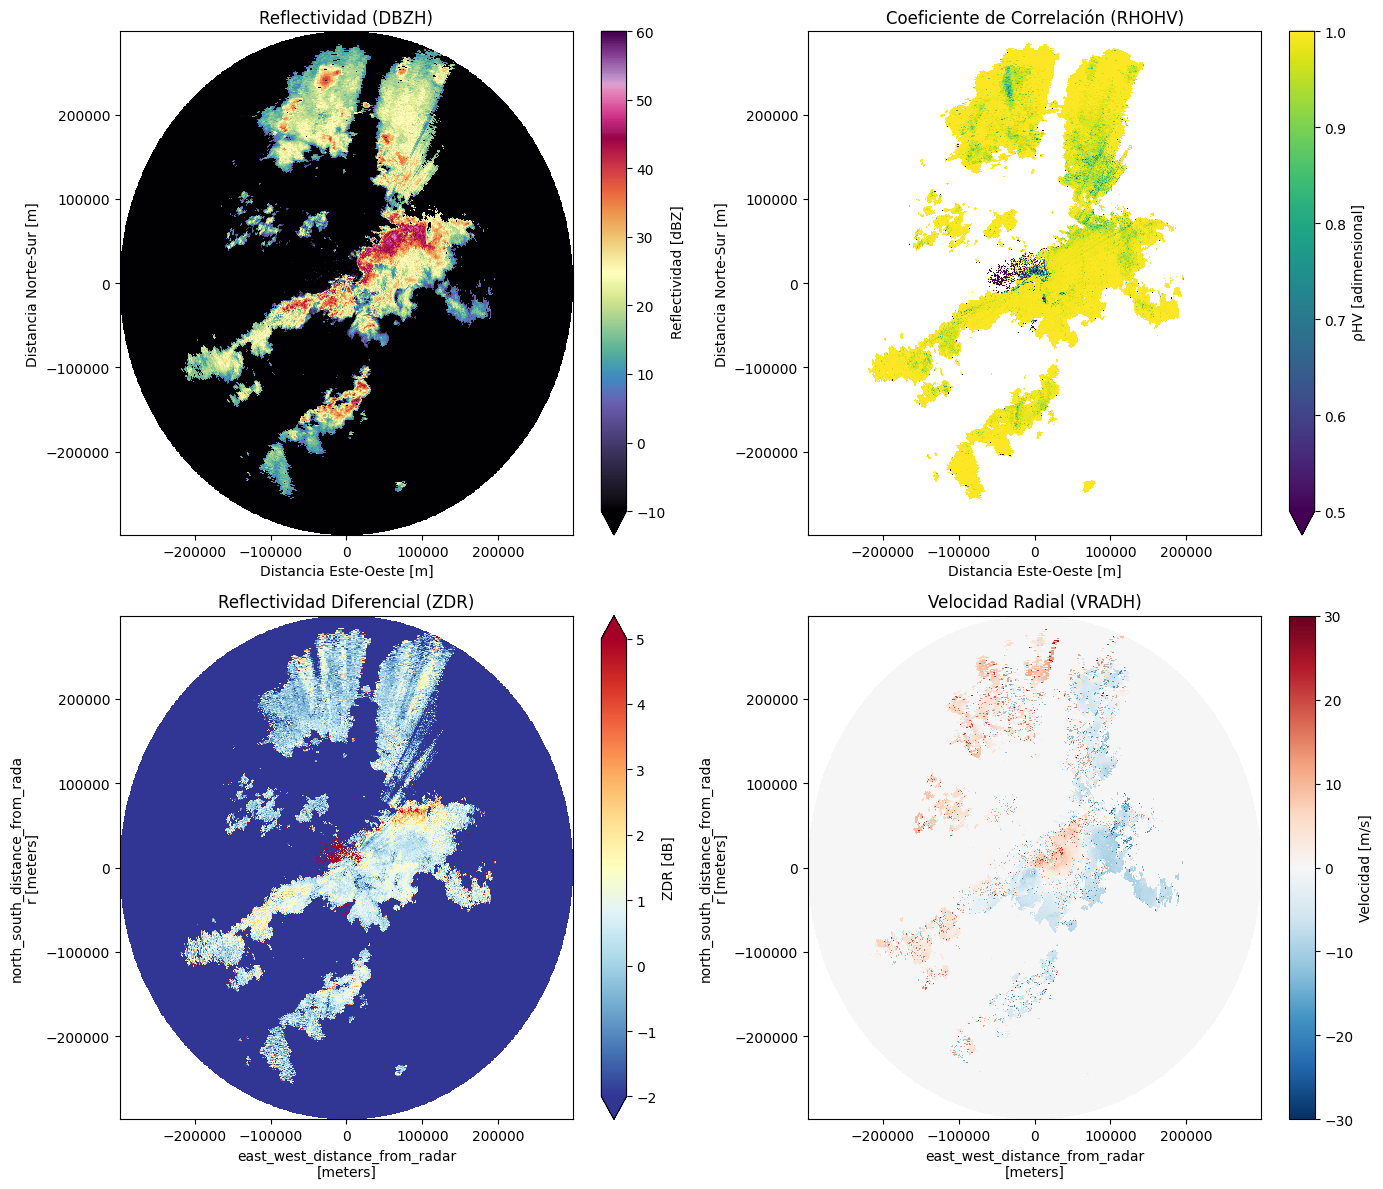

In [6]:
if 'ds' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Reflectividad
    ds.DBZH.plot(x="x", y="y", cmap="ChaseSpectral", 
                 vmin=-10, vmax=60, ax=axes[0, 0],
                 cbar_kwargs={'label': 'Reflectividad [dBZ]'})
    axes[0, 0].set_title('Reflectividad (DBZH)')
    axes[0, 0].set_xlabel('Distancia Este-Oeste [m]')
    axes[0, 0].set_ylabel('Distancia Norte-Sur [m]')
    
    # Coeficiente de correlación
    ds.RHOHV.plot(x="x", y="y", cmap="viridis",
                  vmin=0.5, vmax=1.0, ax=axes[0, 1],
                  cbar_kwargs={'label': 'ρHV [adimensional]'})
    axes[0, 1].set_title('Coeficiente de Correlación (RHOHV)')
    axes[0, 1].set_xlabel('Distancia Este-Oeste [m]')
    axes[0, 1].set_ylabel('Distancia Norte-Sur [m]')
    
    # Reflectividad diferencial (si existe)
    if 'ZDR' in ds.data_vars:
        ds.ZDR.plot(x="x", y="y", cmap="RdYlBu_r",
                    vmin=-2, vmax=5, ax=axes[1, 0],
                    cbar_kwargs={'label': 'ZDR [dB]'})
        axes[1, 0].set_title('Reflectividad Diferencial (ZDR)')
    else:
        axes[1, 0].text(0.5, 0.5, 'ZDR no disponible', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Reflectividad Diferencial (ZDR)')
    
    # Velocidad radial (si existe)
    if 'VRADH' in ds.data_vars:
        ds.VRADH.plot(x="x", y="y", cmap="RdBu_r",
                     vmin=-30, vmax=30, ax=axes[1, 1],
                     cbar_kwargs={'label': 'Velocidad [m/s]'})
        axes[1, 1].set_title('Velocidad Radial (VRADH)')
    else:
        axes[1, 1].text(0.5, 0.5, 'VRADH no disponible',
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Velocidad Radial (VRADH)')
    
    plt.tight_layout()
    plt.savefig('../visualizaciones/ideam/variables_polarimetricas.png', dpi=300, bbox_inches='tight')
    plt.show()

## 7. Filtrado de Datos usando Variables Polarimétricas

### Criterios de Calidad
- **DBZH ≥ -10 dBZ**: Eliminar ruido de fondo
- **RHOHV ≥ 0.80-0.85**: Eliminar ecos no meteorológicos
- **ZDR**: -2 dB < ZDR < 5 dB (rangos típicos de precipitación)

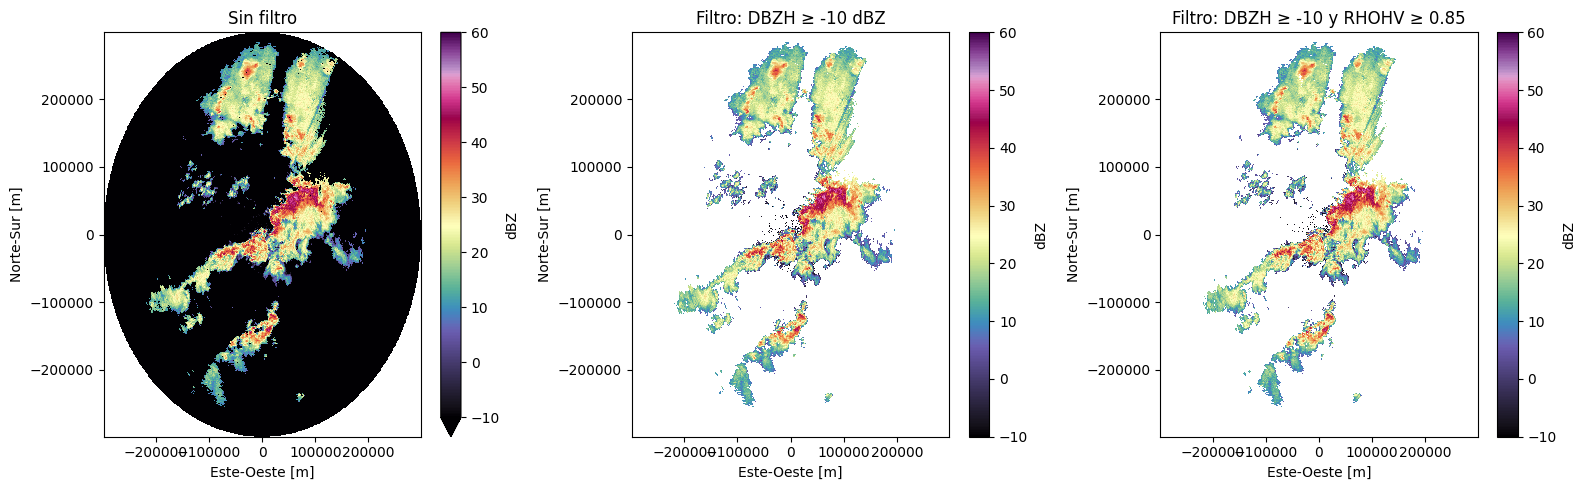

In [7]:
if 'ds' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Sin filtro
    ds.DBZH.plot(x="x", y="y", cmap="ChaseSpectral",
                 vmin=-10, vmax=60, ax=axes[0],
                 cbar_kwargs={'label': 'dBZ'})
    axes[0].set_title('Sin filtro')
    
    # Filtro básico (DBZH ≥ -10)
    ds.DBZH.where(ds.DBZH >= -10).plot(
        x="x", y="y", cmap="ChaseSpectral",
        vmin=-10, vmax=60, ax=axes[1],
        cbar_kwargs={'label': 'dBZ'})
    axes[1].set_title('Filtro: DBZH ≥ -10 dBZ')
    
    # Filtro con correlación (DBZH ≥ -10 y RHOHV ≥ 0.85)
    ds.DBZH.where(ds.DBZH >= -10).where(ds.RHOHV >= 0.85).plot(
        x="x", y="y", cmap="ChaseSpectral",
        vmin=-10, vmax=60, ax=axes[2],
        cbar_kwargs={'label': 'dBZ'})
    axes[2].set_title('Filtro: DBZH ≥ -10 y RHOHV ≥ 0.85')
    
    for ax in axes:
        ax.set_xlabel('Este-Oeste [m]')
        ax.set_ylabel('Norte-Sur [m]')
    
    plt.tight_layout()
    plt.savefig('../visualizaciones/ideam/filtrado_calidad.png', dpi=300, bbox_inches='tight')
    plt.show()

## 8. Leer con PyART para Análisis Avanzado

PyART proporciona herramientas adicionales para:
- Correcciones atmosféricas
- Cálculo de KDP
- Estimación de lluvia (QPE)
- Visualización en mapas

In [8]:
if PYART_AVAILABLE and len(radar_files) > 0:
    # Leer con PyART
    radar = pyart.io.read_sigmet(f"s3://{radar_files[7].split('s3://')[-1]}")
    
    print("✅ Archivo leído con PyART")
    print(f"\n📊 Información del radar:")
    print(f"  - Sweeps: {radar.nsweeps}")
    print(f"  - Campos disponibles: {list(radar.fields.keys())}")
    print(f"  - Ubicación: ({radar.latitude['data'][0]:.4f}, {radar.longitude['data'][0]:.4f})")
    
    # Estadísticas de reflectividad
    if 'reflectivity' in radar.fields:
        refl = radar.fields['reflectivity']['data']
        print(f"\n⚡ Estadísticas de Reflectividad:")
        print(f"  - Máximo: {np.ma.max(refl):.2f} dBZ")
        print(f"  - Promedio: {np.ma.mean(refl):.2f} dBZ")
        print(f"  - Desviación: {np.ma.std(refl):.2f} dBZ")

✅ Archivo leído con PyART

📊 Información del radar:
  - Sweeps: 1
  - Campos disponibles: ['total_power', 'reflectivity', 'velocity', 'spectrum_width', 'differential_reflectivity', 'specific_differential_phase', 'differential_phase', 'normalized_coherent_power', 'cross_correlation_ratio', 'radar_echo_classification']
  - Ubicación: (4.5637, -71.3327)

⚡ Estadísticas de Reflectividad:
  - Máximo: 56.50 dBZ
  - Promedio: 20.82 dBZ
  - Desviación: 11.58 dBZ


## 9. Visualización con PyART RadarMapDisplay

ValueError: 'pyart_NWSRef' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'BlueBrown10', 'BlueBrown10_r', 'BlueBrown11', 'BlueBrown11_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BrBu10', 'BrBu10_r', 'BrBu12', 'BrBu12_r', 'Bu10', 'Bu10_r', 'Bu7', 'Bu7_r', 'BuDOr12', 'BuDOr12_r', 'BuDOr18', 'BuDOr18_r', 'BuDRd12', 'BuDRd12_r', 'BuDRd18', 'BuDRd18_r', 'BuGn', 'BuGn_r', 'BuGr14', 'BuGr14_r', 'BuGy8', 'BuGy8_r', 'BuOr10', 'BuOr10_r', 'BuOr12', 'BuOr12_r', 'BuOr8', 'BuOr8_r', 'BuOrR14', 'BuOrR14_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'CM_depol', 'CM_depol_r', 'CM_rhohv', 'CM_rhohv_r', 'Carbone11', 'Carbone11_r', 'Carbone17', 'Carbone17_r', 'Carbone42', 'Carbone42_r', 'Cat12', 'Cat12_r', 'ChaseSpectral', 'ChaseSpectral_r', 'Dark2', 'Dark2_r', 'EWilson17', 'EWilson17_r', 'GnBu', 'GnBu_r', 'GrMg16', 'GrMg16_r', 'Gray5', 'Gray5_r', 'Gray9', 'Gray9_r', 'Grays', 'Grays_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'HomeyerRainbow', 'HomeyerRainbow_r', 'LangRainbow12', 'LangRainbow12_r', 'NWSRef', 'NWSRef_r', 'NWSVel', 'NWSVel_r', 'NWS_CC', 'NWS_CC_r', 'NWS_SPW', 'NWS_SPW_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PD17', 'PD17_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RRate11', 'RRate11_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu11b', 'RdYlBu11b_r', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'RefDiff', 'RefDiff_r', 'SCook18', 'SCook18_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'SpectralExtended', 'SpectralExtended_r', 'Spectral_r', 'StepSeq25', 'StepSeq25_r', 'SymGray12', 'SymGray12_r', 'Theodore16', 'Theodore16_r', 'Wild25', 'Wild25_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'balance', 'balance_r', 'berlin', 'berlin_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_grey_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gist_yerg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'grey_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'managua', 'managua_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'plasmidis', 'plasmidis_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'vanimo', 'vanimo_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

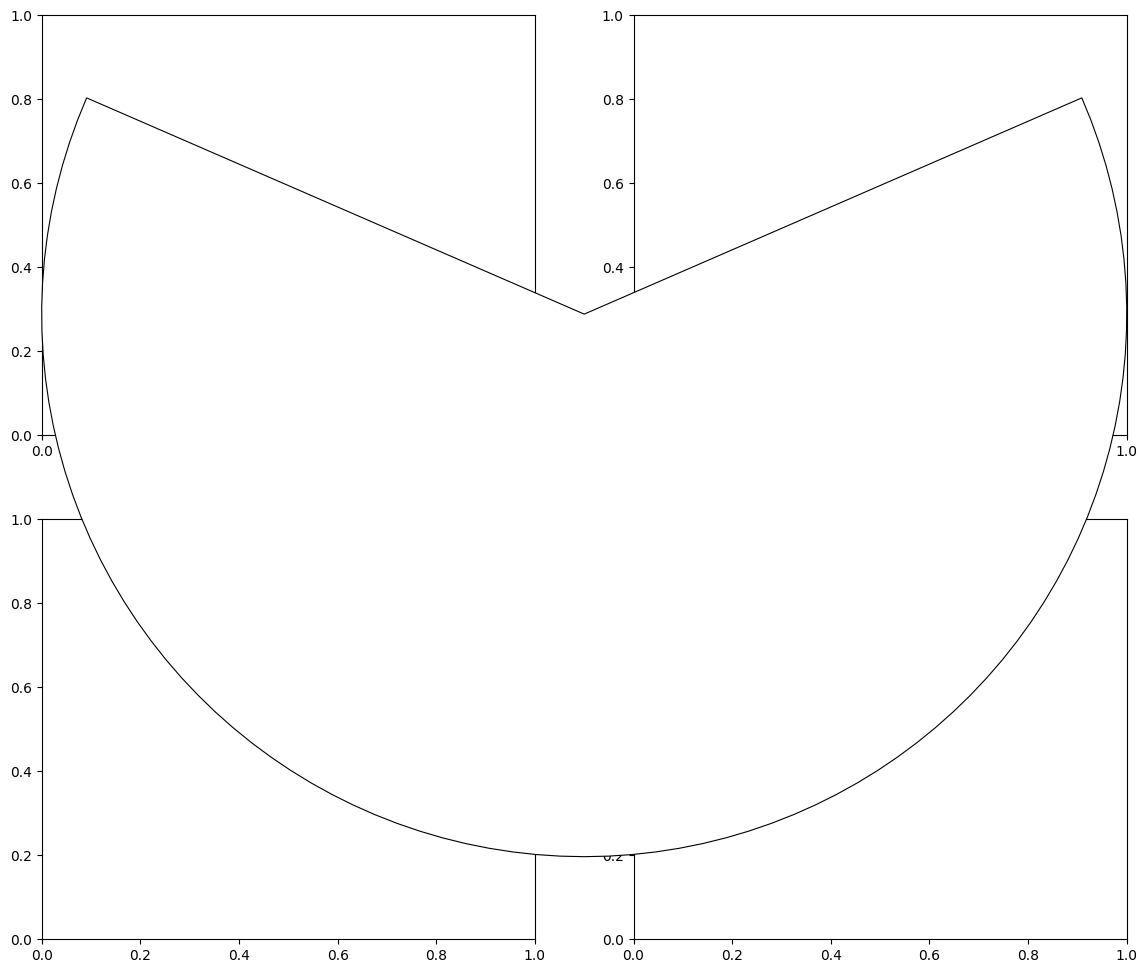

In [10]:
if PYART_AVAILABLE and 'radar' in locals():
    # Crear display
    display = pyart.graph.RadarMapDisplay(radar)
    
    # Configurar figura
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # Extraer coordenadas para centrar el mapa
    lat_center = round(radar.latitude['data'][0], 0)
    lon_center = round(radar.longitude['data'][0], 0)
    lat_ticks = np.arange(lat_center-2, lat_center+2, 1)
    lon_ticks = np.arange(lon_center-2, lon_center+2, 1)
    
    # Reflectividad
    display.plot_ppi_map("reflectivity", 0, resolution='10m',
                         ax=axes[0, 0], lat_lines=lat_ticks, lon_lines=lon_ticks,
                         vmin=-10, vmax=60, cmap='pyart_NWSRef')
    axes[0, 0].set_title('Reflectividad')
    
    # Velocidad
    if 'velocity' in radar.fields:
        display.plot_ppi_map("velocity", 0, resolution='10m',
                             ax=axes[0, 1], lat_lines=lat_ticks, lon_lines=lon_ticks,
                             vmin=-30, vmax=30, cmap='pyart_NWSVel')
        axes[0, 1].set_title('Velocidad Radial')
    
    # Ancho espectral
    if 'spectrum_width' in radar.fields:
        display.plot_ppi_map("spectrum_width", 0, resolution='10m',
                             ax=axes[1, 0], lat_lines=lat_ticks, lon_lines=lon_ticks,
                             vmin=0, vmax=10, cmap='pyart_NWS_SPW')
        axes[1, 0].set_title('Ancho Espectral')
    
    # Correlación
    if 'cross_correlation_ratio' in radar.fields:
        display.plot_ppi_map("cross_correlation_ratio", 0, resolution='10m',
                             ax=axes[1, 1], lat_lines=lat_ticks, lon_lines=lon_ticks,
                             vmin=0.5, vmax=1.0)
        axes[1, 1].set_title('Coeficiente de Correlación')
    
    plt.tight_layout()
    plt.savefig('../visualizaciones/ideam/pyart_display.png', dpi=300, bbox_inches='tight')
    plt.show()

## 10. Extracción de Estadísticas para DataFrame

Crear DataFrame con estadísticas de cada archivo

In [11]:
def extract_radar_stats(file_path):
    """
    Extrae estadísticas de un archivo de radar IDEAM
    
    Args:
        file_path: ruta del archivo en S3
    
    Returns:
        dict: diccionario con estadísticas
    """
    try:
        # Leer archivo
        radar = pyart.io.read_sigmet(f"s3://{file_path.split('s3://')[-1]}")
        
        # Extraer información básica
        stats = {
            'archivo': file_path.split('/')[-1],
            'timestamp': datetime.strptime(
                file_path.split('/')[-1][3:15], '%y%m%d%H%M%S'
            ),
            'radar': file_path.split('/')[-2],
            'lat': float(radar.latitude['data'][0]),
            'lon': float(radar.longitude['data'][0]),
            'alt': float(radar.altitude['data'][0]),
            'nsweeps': radar.nsweeps,
        }
        
        # Estadísticas de reflectividad
        if 'reflectivity' in radar.fields:
            refl = radar.fields['reflectivity']['data']
            stats['refl_max'] = float(np.ma.max(refl))
            stats['refl_mean'] = float(np.ma.mean(refl))
            stats['refl_std'] = float(np.ma.std(refl))
            stats['refl_coverage'] = (np.ma.count(refl) / refl.size) * 100
        
        # Estadísticas de velocidad
        if 'velocity' in radar.fields:
            vel = radar.fields['velocity']['data']
            stats['vel_max'] = float(np.ma.max(np.abs(vel)))
            stats['vel_mean'] = float(np.ma.mean(vel))
        
        # Estadísticas de correlación
        if 'cross_correlation_ratio' in radar.fields:
            rhohv = radar.fields['cross_correlation_ratio']['data']
            stats['rhohv_mean'] = float(np.ma.mean(rhohv))
            stats['rhohv_min'] = float(np.ma.min(rhohv))
        
        return stats
        
    except Exception as e:
        print(f"Error procesando {file_path}: {e}")
        return None

# Procesar varios archivos (limitar para demo)
if PYART_AVAILABLE and len(radar_files) > 0:
    print("🔄 Procesando archivos...")
    stats_list = []
    
    for file in radar_files[:10]:  # Primeros 10 archivos
        stats = extract_radar_stats(file)
        if stats:
            stats_list.append(stats)
        print(f"  ✓ {file.split('/')[-1]}")
    
    # Crear DataFrame
    df_radar = pd.DataFrame(stats_list)
    
    print(f"\n✅ DataFrame creado con {len(df_radar)} registros")
    display(df_radar.head())

🔄 Procesando archivos...
  ✓ CAR220809190003.RAWDSVV
  ✓ CAR220809190315.RAWDSW0
  ✓ CAR220809190401.RAWDSW3
  ✓ CAR220809190505.RAWDSW8
  ✓ CAR220809191003.RAWDSWM
  ✓ CAR220809191314.RAWDSWT
  ✓ CAR220809191400.RAWDSWX
  ✓ CAR220809191504.RAWDSX2
  ✓ CAR220809191817.RAWDSX7
  ✓ CAR220809191903.RAWDSXA

✅ DataFrame creado con 10 registros


TypeError: 'RadarMapDisplay' object is not callable

## 11. Análisis Temporal

Analizar evolución temporal de la reflectividad

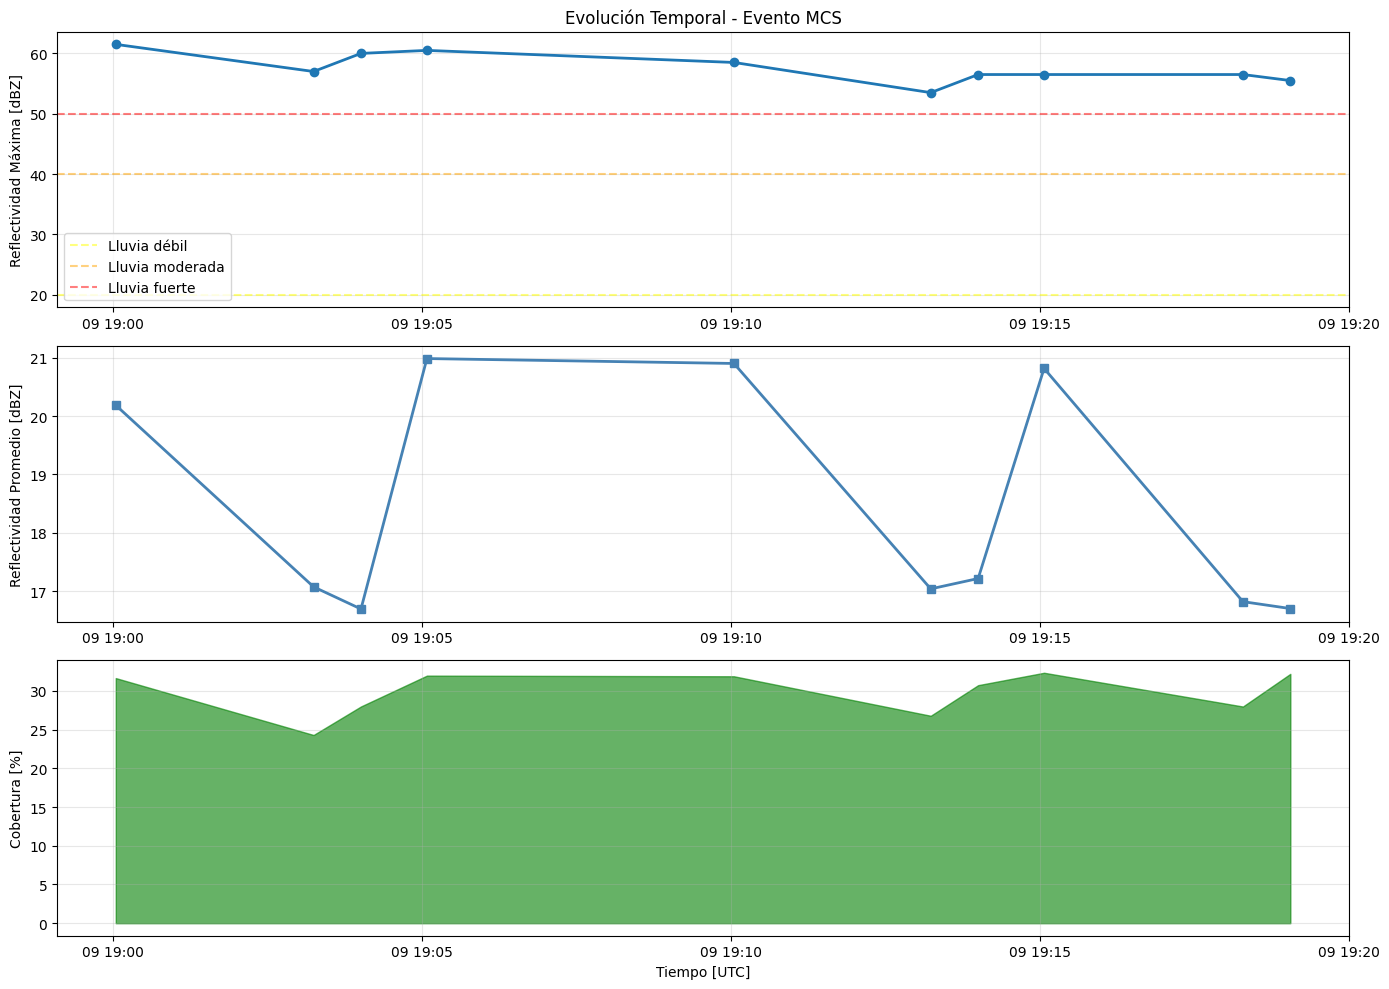

In [12]:
if 'df_radar' in locals() and len(df_radar) > 0:
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    # Serie temporal de reflectividad máxima
    axes[0].plot(df_radar['timestamp'], df_radar['refl_max'], 
                 marker='o', linewidth=2, markersize=6)
    axes[0].axhline(y=20, color='yellow', linestyle='--', alpha=0.5, label='Lluvia débil')
    axes[0].axhline(y=40, color='orange', linestyle='--', alpha=0.5, label='Lluvia moderada')
    axes[0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='Lluvia fuerte')
    axes[0].set_ylabel('Reflectividad Máxima [dBZ]')
    axes[0].set_title('Evolución Temporal - Evento MCS')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Serie temporal de reflectividad promedio
    axes[1].plot(df_radar['timestamp'], df_radar['refl_mean'],
                 marker='s', color='steelblue', linewidth=2, markersize=6)
    axes[1].set_ylabel('Reflectividad Promedio [dBZ]')
    axes[1].grid(True, alpha=0.3)
    
    # Cobertura del radar
    if 'refl_coverage' in df_radar.columns:
        axes[2].fill_between(df_radar['timestamp'], df_radar['refl_coverage'],
                            alpha=0.6, color='green')
        axes[2].set_ylabel('Cobertura [%]')
        axes[2].set_xlabel('Tiempo [UTC]')
        axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../visualizaciones/ideam/evolucion_temporal.png', dpi=300, bbox_inches='tight')
    plt.show()

## 12. Exportar Datos Procesados

In [13]:
if 'df_radar' in locals():
    # Crear directorio de salida
    output_dir = Path('../data/processed')
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Exportar a CSV
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    csv_path = output_dir / f"radar_aws_{radar_name}_{timestamp}.csv"
    df_radar.to_csv(csv_path, index=False)
    print(f"✅ CSV exportado: {csv_path}")
    
    # Exportar a JSON
    json_path = output_dir / f"radar_aws_{radar_name}_{timestamp}.json"
    df_radar.to_json(json_path, orient='records', date_format='iso', indent=2)
    print(f"✅ JSON exportado: {json_path}")
    
    # Resumen
    print(f"\n📊 Resumen del procesamiento:")
    print(f"  - Radar: {radar_name}")
    print(f"  - Fecha: {date_query.strftime('%Y-%m-%d %H:%M')}")
    print(f"  - Archivos procesados: {len(df_radar)}")
    print(f"  - Reflectividad máxima del evento: {df_radar['refl_max'].max():.2f} dBZ")
    print(f"  - Cobertura promedio: {df_radar['refl_coverage'].mean():.1f}%")

✅ CSV exportado: ..\data\processed\radar_aws_Carimagua_20251213_165746.csv
✅ JSON exportado: ..\data\processed\radar_aws_Carimagua_20251213_165746.json

📊 Resumen del procesamiento:
  - Radar: Carimagua
  - Fecha: 2022-08-09 19:00
  - Archivos procesados: 10
  - Reflectividad máxima del evento: 61.50 dBZ
  - Cobertura promedio: 29.8%


## 13. Resumen y Mejores Prácticas

### ✅ Lo que hemos aprendido:

1. **Acceso a datos IDEAM desde AWS S3**
   - Estructura del bucket y nomenclatura de archivos
   - Uso de boto3 y fsspec para acceso programático

2. **Procesamiento con xradar**
   - Lectura de formato Sigmet
   - Conversión a xarray/CfRadial
   - Georreferenciación de datos

3. **Procesamiento con PyART**
   - Lectura y análisis de datos de radar
   - Visualización con RadarMapDisplay
   - Extracción de estadísticas

4. **Control de calidad**
   - Filtrado usando RHOHV
   - Eliminación de ruido
   - Umbrales de reflectividad

5. **Análisis temporal**
   - Series temporales de reflectividad
   - Identificación de eventos meteorológicos
   - Evolución de la cobertura

### 📚 Referencias Adicionales:
- [IDEAM Radar Data](https://registry.opendata.aws/ideam-radares/)
- [xradar Documentation](https://docs.openradarscience.org/projects/xradar/)
- [PyART Documentation](https://arm-doe.github.io/pyart/)
- [Project Pythia Radar Cookbook](https://projectpythia.org/radar-cookbook/)
- [AWS RADARESCOL PDF](http://www.pronosticosyalertas.gov.co/documents/78690/112207077/AWS_RADARESCOL.pdf/)

### 🔧 Instalación de Dependencias:
```bash
pip install arm-pyart xradar fsspec boto3 s3fs
```

---
**Notebook creado:** Diciembre 2025  
**Basado en:** Project Pythia Radar Cookbook y xradar documentation  
**Fuente de datos:** IDEAM - Instituto de Hidrología, Meteorología y Estudios Ambientales  
**Licencia:** Open Data (AWS Public Dataset)